In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics

### Funciones

In [2]:
def pair_histogram(X_train,y_train, n_bin_nopulsar, n_bin_pulsar, DRAW=True):
    prob_dict_nopulsar = {}
    bins_dict_nopulsar = {}
    prob_dict_pulsar = {}
    bins_dict_pulsar = {}
    for col in X_train.columns:
        # Guardar histogramas para caso no pulsar y pulsar para cada variable
        f_nopulsar, bins_nopulsar, n = plt.hist(X_train[col].loc[y_train == 0], 
                                                n_bin_nopulsar[col], color = "b", alpha=0.4, label = 'No pulsar')
        f_pulsar, bins_pulsar, n = plt.hist(X_train[col].loc[y_train == 1], 
                                                n_bin_pulsar[col], color = "r", alpha = 0.4, label = 'Pulsar')
        plt.title("Histograma {}".format(col))
        plt.legend()
        #normalizar histograma y guardar en un diccionario
        prob_dict_nopulsar[col] = f_nopulsar/X_train[col].loc[y_train == 0].shape[0]
        prob_dict_pulsar[col] = f_pulsar/X_train[col].loc[y_train == 1].shape[0]
        bins_dict_nopulsar[col] = bins_nopulsar
        bins_dict_pulsar[col] = bins_pulsar
        if DRAW:
            plt.savefig('Histograma {}'.format(col))
            plt.show()
        plt.clf()
    return prob_dict_nopulsar, prob_dict_pulsar, bins_dict_nopulsar, bins_dict_pulsar

In [3]:
def probabilidad_histograma(x, array_bins, array_probabilidades):
    #dado los bins y la probabilidad de cada bin esta funcion 
    #revisa a que bin corresponde una nueva observacion y entrega su probailidad asociada
    dic = {}
    if x < array_bins[0]:
        dic["probabilidad"] = 0
        dic["bin"] = [array_bins[0]]
        dic["tag"] = "min"
        return dic
    if x > array_bins[array_bins.shape[0] - 1]:
        dic["probabilidad"] = 0
        dic["bin"] = [array_bins[array_bins.shape[0] - 1]]
        dic["tag"] = "max"
        return dic
    for i in range(array_bins.shape[0] -1): #no necesito "pararme" en el ultimo valor
        if (array_bins[i] <= x) & (x <= array_bins[i+1]):
            dic["probabilidad"] = array_probabilidades[i]
            dic["bin"] = [array_bins[i], array_bins[i+1]]
            dic["tag"] = "int"
            return  dic

In [4]:
def probabilidad_array(array,cols,prob_dict_nopulsar, prob_dict_pulsar, bins_dict_nopulsar, bins_dict_pulsar):
    p_nopulsar = 1
    p_pulsar = 1
    for i in range(8):
        p_nopulsar = probabilidad_histograma(array[i],bins_dict_nopulsar[cols[i]],prob_dict_nopulsar[cols[i]])["probabilidad"]*p_nopulsar
        p_pulsar = probabilidad_histograma(array[i],bins_dict_pulsar[cols[i]],prob_dict_pulsar[cols[i]])["probabilidad"]*p_pulsar
    return p_nopulsar, p_pulsar

In [5]:
def mult_gaus(x,mu_nopulsar,mu_pulsar,cov_nopulsar,cov_pulsar):

    constante_nopulsar = 1/  ( (2*np.pi)**(8/2)*np.linalg.det(cov_nopulsar))
    constante_pulsar = 1/  ( (2*np.pi)**(8/2)*np.linalg.det(cov_pulsar))
    
    exp_nopulsar = np.exp( -(1/2)*np.matrix(x[0:8]-mu_nopulsar)*np.linalg.inv(cov_nopulsar)*np.transpose(np.matrix(x[0:8]-mu_nopulsar)) )
    exp_pulsar = np.exp( -(1/2)*np.matrix(x[0:8]-mu_pulsar)*np.linalg.inv(cov_pulsar)*np.transpose(np.matrix(x[0:8]-mu_pulsar)) )
    prob_nopulsar = constante_nopulsar*exp_nopulsar
    prob_pulsar = constante_pulsar*exp_pulsar
    return prob_nopulsar[0,0], prob_pulsar[0,0]

In [6]:
def roc_curve(y_true, prob_nopulsar,prob_pulsar, title):
    threshold = np.logspace(-100,0,num=500)
    tp_list = [1]
    fp_list = [1]
    for t in threshold:
        tp = 0
        fp = 0
        for true, nopulsar, pulsar in zip(y_true, prob_nopulsar, prob_pulsar):
            if (true == 1) & (pulsar > t*nopulsar):
                tp = tp + 1
            if (true == 0) & (pulsar > t*nopulsar):
                fp = fp + 1
        tp = tp / np.sum(y_true == 1)
        fp = fp / np.sum(y_true == 0)
        tp_list.append(tp)
        fp_list.append(fp)
    tp_list.append(0)
    fp_list.append(0)
    plt.plot(fp_list,tp_list)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('Receiver Operating Characteristic')

    plt.savefig(title)
    plt.show()
    return np.array(fp_list) ,np.array(tp_list), threshold

### Dividir dataset 80%-20% conservando la proporción original

In [7]:
cols = ['col_1','col_2','col_3','col_4','col_5','col_6','col_7','col_8','label']
df = pd.read_csv("HTRU_2.csv",sep = ',')
df.columns = cols # df no tiene nulls

In [8]:
y = df.label
X = df.drop(labels = "label", axis = 1)
X_train_hist, X_test_hist, y_train_hist, y_test_hist = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_gaus, X_test_gaus, y_train_gaus, y_test_gaus = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
original_pulsar_rate = np.sum(df.label == 1)/df.shape[0]
original_nopulsar_rate = np.sum(df.label == 0)/df.shape[0]
train_pulsar_rate = np.sum(y_train_hist == 1)/y_train_hist.shape[0]
train_nopulsar_rate = np.sum(y_train_hist == 0)/y_train_hist.shape[0]
test_pulsar_rate = np.sum(y_test_hist == 1)/y_test_hist.shape[0]
test_nopulsar_rate = np.sum(y_test_hist == 0)/y_test_hist.shape[0]
print("original rates: pulsar= {}, nopulsar= {}".format(original_pulsar_rate,original_nopulsar_rate))
print("train rates: pulsar= {}, nopulsar= {}".format(train_pulsar_rate,train_nopulsar_rate))
print("test rates: pulsar= {}, nopulsar= {}".format(test_pulsar_rate,test_nopulsar_rate))

original rates: pulsar= 0.09157959434542103, nopulsar= 0.9084204056545789
train rates: pulsar= 0.09205839212125445, nopulsar= 0.9079416078787456
test rates: pulsar= 0.08966480446927375, nopulsar= 0.9103351955307263


### Histogramas

In [10]:
#Definicion de numero de bins
n_bin_nopulsar = {
    "col_1": 5,
    "col_2": 5,
    "col_3": 5,
    "col_4": 5,
    "col_5": 5,
    "col_6": 5,
    "col_7": 5,
    "col_8": 5,
}
n_bin_pulsar = n_bin_nopulsar

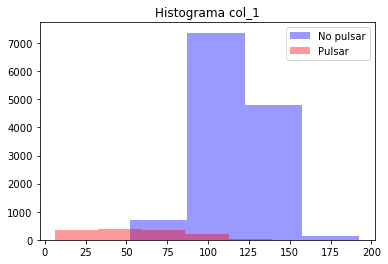

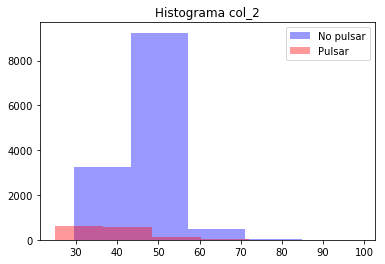

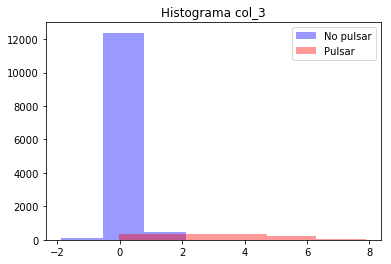

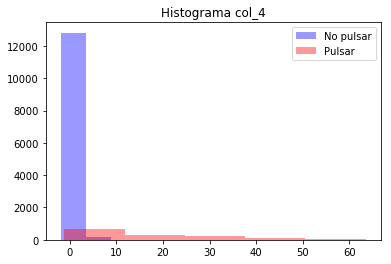

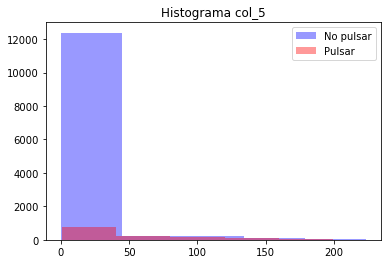

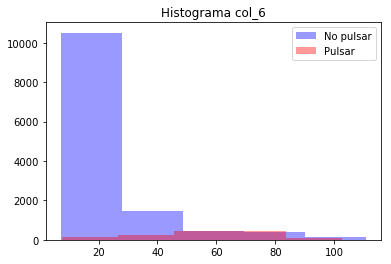

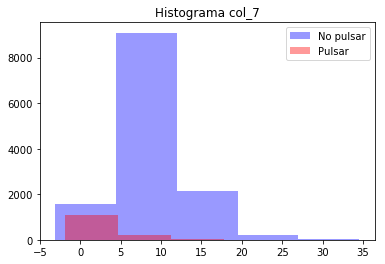

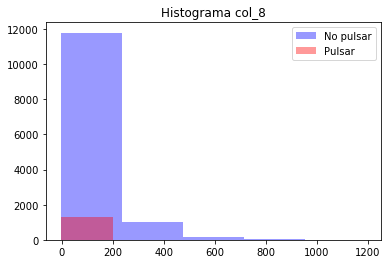

C:\Users\bldr1\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\bldr1\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [11]:
# Calculo de probabilidades de clase no pulsar, pulsar y grafico de histogramas
prob_dict_nopulsar, prob_dict_pulsar, bins_dict_nopulsar, bins_dict_pulsar = pair_histogram(X_train_hist,y_train_hist,n_bin_nopulsar, n_bin_pulsar)
X_test_hist["prob_nopulsar"] = X_test_hist.apply(lambda x: train_nopulsar_rate*probabilidad_array(x,cols,prob_dict_nopulsar, prob_dict_pulsar, bins_dict_nopulsar, bins_dict_pulsar)[0], axis =1)
X_test_hist["prob_pulsar"] = X_test_hist.apply(lambda x: train_pulsar_rate*probabilidad_array(x,cols,prob_dict_nopulsar, prob_dict_pulsar, bins_dict_nopulsar, bins_dict_pulsar)[1], axis =1)

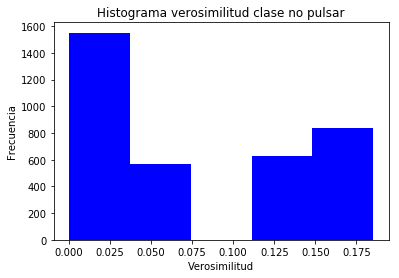

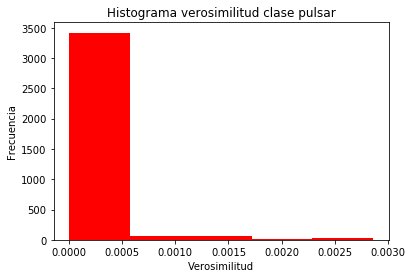

In [12]:
# Graficar verosimilitudes modelo con histogramas
%matplotlib inline
plt.hist(X_test_hist.prob_nopulsar/train_nopulsar_rate, bins = 5,color = 'b')
plt.title("Histograma verosimilitud clase no pulsar")
plt.xlabel("Verosimilitud")
plt.ylabel("Frecuencia")
plt.savefig("Verosimilitud_no_pulsar")
plt.show()
plt.hist(X_test_hist.prob_pulsar/train_pulsar_rate, bins = 5, color = 'r')
plt.title("Histograma verosimilitud clase pulsar")
plt.xlabel("Verosimilitud")
plt.ylabel("Frecuencia")
plt.savefig("Verosimilitud_pulsar")
plt.show()

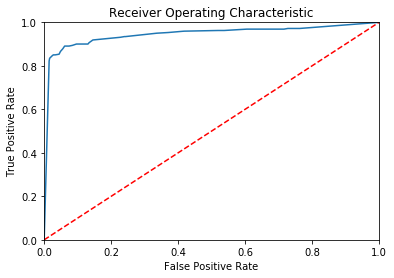

In [13]:
# Grafico curva ROC
fpr, tpr, threshold = roc_curve(y_test_hist,X_test_hist.prob_nopulsar, X_test_hist.prob_pulsar,'ROC_hist')

## Modelo Gaussiano

In [14]:
# Calculo de vector de medias y matriz de covarianza (y determinante)
mu_nopulsar = np.mean(X_train_gaus[y_train_gaus == 0])
mu_pulsar = np.mean(X_train_gaus[y_train_gaus == 1])

cov_nopulsar = X_train_gaus[y_train_gaus == 0].cov()
cov_pulsar = X_train_gaus[y_train_gaus == 1].cov()

determinante_nopulsar = np.linalg.det(cov_nopulsar)
determinante_pulsar = np.linalg.det(cov_pulsar)

In [15]:
# Calculo de probabilidad de clase no pulsar y pulsar
X_test_gaus["prob_nopulsar"] = X_test_gaus.apply(lambda x: train_nopulsar_rate*mult_gaus(x,mu_nopulsar,mu_pulsar,cov_nopulsar,cov_pulsar)[0], axis = 1)
X_test_gaus["prob_pulsar"] = X_test_gaus.apply(lambda x: train_pulsar_rate*mult_gaus(x,mu_pulsar,mu_pulsar,cov_pulsar,cov_pulsar)[1], axis = 1)

C:\Users\bldr1\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\bldr1\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


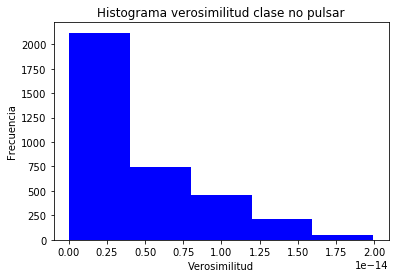

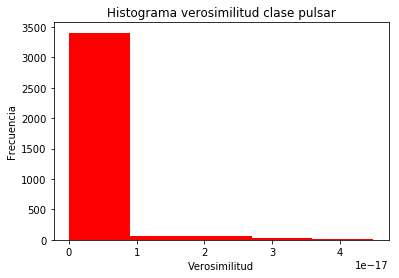

In [16]:
# Grafico de verosimilitudes
%matplotlib inline
plt.hist(X_test_gaus.prob_nopulsar/train_nopulsar_rate, bins = 5,color = 'b')
plt.title("Histograma verosimilitud clase no pulsar")
plt.xlabel("Verosimilitud")
plt.ylabel("Frecuencia")
plt.savefig("Verosimilitud_no_pulsar_gaus")
plt.show()
plt.hist(X_test_gaus.prob_pulsar/train_pulsar_rate, bins = 5, color = 'r')
plt.title("Histograma verosimilitud clase pulsar")
plt.xlabel("Verosimilitud")
plt.ylabel("Frecuencia")
plt.savefig("Verosimilitud_pulsar_gaus")
plt.show()

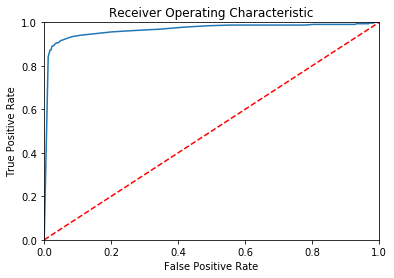

In [17]:
# Grafico curva ROC
fpr, tpr, threshold = roc_curve(y_test_gaus,X_test_gaus.prob_nopulsar, X_test_gaus.prob_pulsar,'ROC_gaus')